In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import os
import numpy as np
import openpyxl
from shapely import wkt
from geoalchemy2.shape import from_shape
import matplotlib.pyplot as plt

### Tom Hindmarsh SID: 530584931 - School Catchments 

#### Clean Catchments Data

In [3]:
srid = 4326

raw_catchments_primary = gpd.read_file('datasets/original/catchments/catchments_primary.shp')
raw_catchments_secondary = gpd.read_file('datasets/original/catchments/catchments_secondary.shp')
raw_catchments_future = gpd.read_file('datasets/original/catchments/catchments_future.shp')

catchments_primary = raw_catchments_primary.copy()
catchments_secondary = raw_catchments_secondary.copy()
catchments_future = raw_catchments_future.copy()

def clean_catchments(catchments_data, catch_type=None):
    # Remove any rows with missing or invalid geometry
    cleaned_data = catchments_data.dropna(subset=['geometry'])
    
    # Remove any rows with missing data
    cleaned_data = cleaned_data[~cleaned_data.isnull().all(axis=1)]
    
    # Remove duplicates based on the 'USE_DESC' column
    cleaned_data = cleaned_data.drop_duplicates(subset=['USE_DESC'])
    
    # Convert geometries to MULTIPOLYGON
    cleaned_data['geometry'] = cleaned_data['geometry'].apply(lambda x: MultiPolygon([x]) if isinstance(x, Polygon) else x)
    
    # Remove columns KINDEGART, YEAR1, YEAR2, ..., YEAR12
    year_columns = [f'YEAR{i}' for i in range(1, 13)]
    cleaned_data = cleaned_data.drop(columns=year_columns, errors='ignore')
    cleaned_data = cleaned_data.drop(columns='KINDERGART', errors='ignore')
    cleaned_data = cleaned_data.drop(columns='PRIORITY', errors='ignore')

    
    if catch_type:
        cleaned_data['CATCH_TYPE'] = catch_type
    
    return cleaned_data

cleaned_catchments_primary = clean_catchments(catchments_primary, catch_type='PRIMARY')
cleaned_catchments_secondary = clean_catchments(catchments_secondary)
cleaned_catchments_future = clean_catchments(catchments_future)

def create_cleaned_file(cleaned_catchments, file_name):
    output_path = os.path.join('datasets/cleaned/catchments/' + f'{file_name}.shp')
    cleaned_catchments.to_file(output_path)

create_cleaned_file(cleaned_catchments_primary, 'cleaned_catchments_primary')
create_cleaned_file(cleaned_catchments_secondary, 'cleaned_catchments_secondary')
create_cleaned_file(cleaned_catchments_future, 'cleaned_catchments_future')

cleaned_catchments_primary

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,geometry
0,2838,PRIMARY,Parklea PS,20181210,"MULTIPOLYGON (((150.93564 -33.71612, 150.93715..."
1,2404,PRIMARY,Lindfield EPS,20211219,"MULTIPOLYGON (((151.18336 -33.74748, 151.18443..."
2,4393,PRIMARY,Carlingford WPS,20220223,"MULTIPOLYGON (((151.04518 -33.77303, 151.04526..."
3,4615,PRIMARY,Caddies Ck PS,20181210,"MULTIPOLYGON (((150.92567 -33.72960, 150.92602..."
4,3918,PRIMARY,Killara PS,20211219,"MULTIPOLYGON (((151.15379 -33.75586, 151.15404..."
...,...,...,...,...,...
1657,4383,PRIMARY,E A Southee PS,20200315,"MULTIPOLYGON (((147.94621 -34.55863, 147.95292..."
1658,3275,PRIMARY,Tumbarumba PS,20200507,"MULTIPOLYGON (((148.12885 -35.60082, 148.23155..."
1659,2239,PRIMARY,Jindera PS,20200507,"MULTIPOLYGON (((146.86148 -35.87511, 146.87402..."
1660,3594,PRIMARY,Louth PS,20200604,"MULTIPOLYGON (((145.18403 -29.65805, 145.18434..."


In [4]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import pandas as pd
import json
import os

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

Connected successfully.


#### Clean Income Data

In [3]:
#Load the dataset from a CSV/SHP file
raw_income_data = pd.read_csv('datasets/original/Income.csv')

# Copy original data to ensure there is a backup
income_data = raw_income_data.copy()

# Rename column names
income_data.rename(columns={'sa2_code21': 'sa2_code'}, inplace=True)

# Rename columns to use underscores and lowercase
income_data.columns = [col.lower().replace(' ', '_') for col in income_data.columns]

# Remove any leading/trailing whitespace from string columns
string_columns = ['sa2_code', 'sa2_name']
income_data[string_columns] = income_data[string_columns].astype(str).apply(lambda x: x.str.strip())

# Convert numeric columns to appropriate data types
numeric_columns = ['earners', 'median_age', 'median_income', 'mean_income']
income_data[numeric_columns] = income_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing or invalid values
income_data.dropna(inplace=True)

# Remove duplicates
income_data.drop_duplicates(inplace=True)

# Create a new CSV file from the cleaned data
income_data.to_csv('datasets/cleaned/cleaned_income.csv', index=False)

income_data

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467.0,51.0,46640.0,68904.0
1,101021008,Karabar,5103.0,42.0,65564.0,69672.0
2,101021009,Queanbeyan,7028.0,39.0,63528.0,69174.0
3,101021010,Queanbeyan - East,3398.0,39.0,66148.0,74162.0
4,101021012,Queanbeyan West - Jerrabomberra,8422.0,44.0,78630.0,91981.0
...,...,...,...,...,...,...
637,128021537,Royal National Park,14.0,37.0,36980.0,47584.0
638,128021538,Sutherland - Kirrawee,13895.0,41.0,64940.0,74867.0
639,128021607,Engadine,10239.0,43.0,63695.0,72995.0
640,128021608,Loftus - Yarrawarrah,4424.0,45.0,63087.0,76440.0


In [ ]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [14]:
conn.close()
db.dispose()


### Thomas Whelan - SID 510459532: Polling Places, Population, Crimes, Dwellings and Registered Cars Datasets

#### Cleaning Polling dataset

In [3]:
pol = pd.read_csv("datasets/original/PollingPlaces2019.csv")
pol

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866)


In [4]:
#Check null values for all variables
pol.isna().sum()

FID                               0
state                             0
division_id                       0
division_name                     0
polling_place_id                  0
polling_place_type_id             0
polling_place_name                0
premises_name                     0
premises_address_1              193
premises_address_2             2816
premises_address_3             2895
premises_suburb                 115
premises_state_abbreviation       0
premises_post_code              109
latitude                        140
longitude                       140
the_geom                        140
dtype: int64

In [17]:
#drop null values for latitude and longitude as this will likely be one of our primary or secondary keys
n_pol = pol.dropna(subset= ['latitude', 'longitude'])
#search for and remove outliers for lat and long
n_pol[(n_pol['latitude'] < -180.0) & (n_pol['latitude'] > 180.0)] #clearly no outliers
#recount NA for latitude and longitude
print(n_pol.isna().sum())

FID                               0
state                             0
division_id                       0
division_name                     0
polling_place_id                  0
polling_place_type_id             0
polling_place_name                0
premises_name                     0
premises_address_1               67
premises_address_2             2677
premises_address_3             2755
premises_suburb                   0
premises_state_abbreviation       0
premises_post_code                0
latitude                          0
longitude                         0
the_geom                          0
dtype: int64


In [18]:
#convert to integer
n_pol.astype({'division_id': 'int64'}).dtypes

FID                             object
state                           object
division_id                      int64
division_name                   object
polling_place_id                 int64
polling_place_type_id            int64
polling_place_name              object
premises_name                   object
premises_address_1              object
premises_address_2              object
premises_address_3              object
premises_suburb                 object
premises_state_abbreviation     object
premises_post_code             float64
latitude                       float64
longitude                      float64
the_geom                        object
dtype: object

In [19]:
# convert to correct SRID
n_pol = n_pol.copy()  # Make a copy of the DataFrame
n_pol['the_geom'] = gpd.points_from_xy(n_pol.longitude, n_pol.latitude)  # creating the geometry column
n_pol = n_pol.drop(columns=['latitude', 'longitude'])  # removing the old latitude/longitude fields

srid = 4283
n_pol['geom'] = n_pol['the_geom'].apply(lambda x: WKTElement(x.wkt, srid=srid)) #converting the SRID
n_pol = n_pol.drop(columns = ['the_geom'])


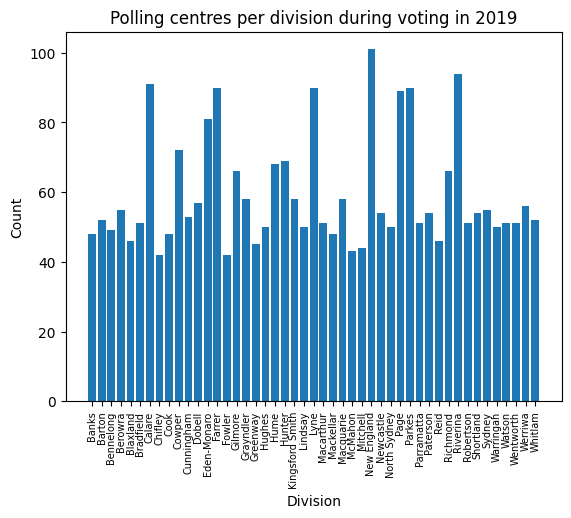

In [20]:
#graph of polling centres per division during voting in 2019
division_count = n_pol.groupby('division_name')['division_name'].count() #groupby count
plt.bar(division_count.index,division_count.values) #barplot
plt.title('Polling centres per division during voting in 2019') #title
plt.xlabel('Division') #xlabel
plt.ylabel('Count') #ylabel
plt.xticks(rotation=90, fontsize = 7) #roatate x-axis label
plt.show() #show plot



In [21]:
#export cleaned dataset
n_pol.to_csv("datasets/cleaned/PollingPlaces2019_cleaned.csv", index= False)

#### Cleaning Population dataset

In [6]:
# read in population
pop = pd.read_csv("datasets/original/Population.csv")
pop

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [23]:
#look at description of dataset
pop.describe().loc[['count','mean','std','min','max']]
#by looking at the description we can see there are no illogical outliers in any of the variables and that the counts are uniform

,sa2_code,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,40-44_people,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
count,3.730000e+02,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.198861e+08,854.737265,890.718499,873.538874,797.010724,941.506702,1079.378016,1141.667560,1119.305630,974.163539,926.337802,860.184987,814.281501,734.670241,618.152815,541.369973,386.790885,268.656836,278.772118,14101.243968
std,6.504069e+06,457.650405,472.605070,465.615660,413.433206,513.399976,711.167860,719.999852,589.994822,453.460847,421.014390,395.336077,376.967453,352.993590,304.425028,281.331172,217.164521,159.342399,204.291009,6039.862248
min,1.020110e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.280216e+08,2576.000000,2576.000000,2066.000000,1771.000000,3279.000000,4586.000000,4507.000000,3664.000000,2549.000000,1924.000000,1840.000000,1737.000000,1829.000000,1675.000000,1786.000000,1362.000000,891.000000,1110.000000,25565.000000


In [24]:
#search for any null values
pop.isna().sum()
#there are none so no need to drop rows or substitute values

sa2_code              0
sa2_name              0
0-4_people            0
5-9_people            0
10-14_people          0
15-19_people          0
20-24_people          0
25-29_people          0
30-34_people          0
35-39_people          0
40-44_people          0
45-49_people          0
50-54_people          0
55-59_people          0
60-64_people          0
65-69_people          0
70-74_people          0
75-79_people          0
80-84_people          0
85-and-over_people    0
total_people          0
dtype: int64

In [25]:
#create a new variable that categorises 'young people'
pop['young'] = np.mean(pop[['0-4_people', '5-9_people']], axis=1, )
pop['young'].round()
pop = pop.astype({'young': 'int64'})


In [26]:
#look at total averages in each area
place_pop = pop.groupby('sa2_name')['total_people'].mean()
place_pop[place_pop == 0]

sa2_name
Centennial Park    0.0
Name: total_people, dtype: float64

In [27]:
#output cleaned dataset
pop.to_csv("datasets/cleaned/Population_cleaned.csv", index= False) #export the file
pop

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people,young
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,602,570,520,464,369,226,142,70,7530,473
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,794,895,863,925,603,331,264,11052,588
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,436,422,397,327,264,190,100,75,4748,212
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,882,901,930,917,1065,976,773,1028,14803,743
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1241,1377,1285,1166,949,664,476,537,21346,1104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,0,0,0,1,0,0,0,0,45,3
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1391,1285,1157,909,909,781,582,807,23369,1405
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1086,909,764,707,886,748,389,327,17379,1220
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,477,450,387,418,335,263,192,109,7354,495


### Cleaning New Datasets
#### Cars dataset


In [7]:
#read in cars
cars = pd.read_csv('datasets/original/ABS_ECONOMY.csv')

In [29]:
#select the rows we need
n_cars = cars.iloc[:, [1,2,3,81]]
n_cars

,Statistical Areas Level 2 2021 code,Statistical Areas Level 2 2021 name,Area in square kilometres,Total registered motor vehicles (no.) (Data year: 2020)
0,101021007,Braidwood,3418.3525,4434.0
1,101021008,Karabar,6.9825,8037.0
2,101021009,Queanbeyan,4.7620,10551.0
3,101021010,Queanbeyan - East,13.0032,4646.0
4,101021012,Queanbeyan West - Jerrabomberra,13.6748,10555.0
...,...,...,...,...
2468,901031003,Jervis Bay,67.2296,360.0
2469,901041004,Norfolk Island,38.6510,13.0
2470,997979799,Migratory - Offshore - Shipping (OT),NaN,NaN
2471,999999499,No usual address (OT),NaN,NaN


In [30]:
#rename columns
cars_colnames = ['sa2_code','sa2_name','area_m2','total_cars']
n_cars.rename(columns=dict(zip(n_cars.columns, cars_colnames)), inplace=True)
n_cars

C:\Users\thoma\AppData\Local\Temp\ipykernel_1932\827941316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_cars.rename(columns=dict(zip(n_cars.columns, cars_colnames)), inplace=True)


,sa2_code,sa2_name,area_m2,total_cars
0,101021007,Braidwood,3418.3525,4434.0
1,101021008,Karabar,6.9825,8037.0
2,101021009,Queanbeyan,4.7620,10551.0
3,101021010,Queanbeyan - East,13.0032,4646.0
4,101021012,Queanbeyan West - Jerrabomberra,13.6748,10555.0
...,...,...,...,...
2468,901031003,Jervis Bay,67.2296,360.0
2469,901041004,Norfolk Island,38.6510,13.0
2470,997979799,Migratory - Offshore - Shipping (OT),NaN,NaN
2471,999999499,No usual address (OT),NaN,NaN


In [31]:
# remove NA values
n_cars = n_cars.dropna()
n_cars.isna().sum()

sa2_code      0
sa2_name      0
area_m2       0
total_cars    0
dtype: int64

In [32]:
#remove all letters in code that may be used as null values
contains_string =  n_cars[n_cars['sa2_code'].str.contains(r'[a-zA-Z]')]
n_cars = n_cars.drop(contains_string.index)
n_cars

,sa2_code,sa2_name,area_m2,total_cars
0,101021007,Braidwood,3418.3525,4434.0
1,101021008,Karabar,6.9825,8037.0
2,101021009,Queanbeyan,4.7620,10551.0
3,101021010,Queanbeyan - East,13.0032,4646.0
4,101021012,Queanbeyan West - Jerrabomberra,13.6748,10555.0
...,...,...,...,...
2462,801111140,ACT - South West,416.7824,477.0
2463,801111141,Namadgi,1202.7527,35.0
2466,901011001,Christmas Island,136.1356,69.0
2468,901031003,Jervis Bay,67.2296,360.0


In [33]:
#export as cars file
n_cars.to_csv("datasets/cleaned/cars_cleaned.csv", index =  False)

#### Dwelling Data

In [8]:
#read in build dataset from worksheet
dwell = pd.read_excel("datasets/original/greater-sydney.xlsx", sheet_name='Net Completions')

In [35]:
#rename columns
dwell = dwell.drop(columns= ['GreenfieldGrowthArea','GreenfieldLabel'], axis= 1)
dwell_col = ['date', 'year', 'LGA','city','sa2_code','sa2_name','dwell_type','net_comp','latitude','longitude']
dwell.rename(columns=dict(zip(dwell.columns, dwell_col)), inplace=True)
dwell

,date,year,LGA,city,sa2_code,sa2_name,dwell_type,net_comp,latitude,longitude
0,2012-07-01,2012-13,Sydney,Eastern Harbour City,117031638,Camperdown - Darlington,Detached,1,-33.892425,151.193632
1,2012-07-01,2012-13,Randwick,Eastern Harbour City,118021565,Kingsford,Multi Unit,5,-33.923832,151.223716
2,2012-07-01,2012-13,Randwick,Eastern Harbour City,118021652,Malabar - La Perouse,Detached,1,-33.964883,151.249700
3,2012-07-01,2012-13,Inner West,Eastern Harbour City,120021675,Leichhardt,Detached,1,-33.877889,151.162507
4,2012-07-01,2012-13,Inner West,Eastern Harbour City,120021675,Leichhardt,Detached,1,-33.884773,151.156595
...,...,...,...,...,...,...,...,...,...,...
119072,2023-06-01,2022-23,The Hills Shire,Central River City,115041623,Box Hill - Nelson,Detached,1,-33.634879,150.889786
119073,2023-06-01,2022-23,Blacktown,Central River City,116021629,Marsden Park - Shanes Park,Detached,1,-33.684961,150.815284
119074,2023-06-01,2022-23,Blacktown,Central River City,116021632,Schofields - East,Detached,1,-33.699952,150.896259
119075,2023-06-01,2022-23,Blacktown,Central River City,116021632,Schofields - East,Detached,1,-33.699952,150.896259


In [36]:
#look for any NA values
dwell.isna().sum()

date          0
year          0
LGA           0
city          0
sa2_code      0
sa2_name      0
dwell_type    0
net_comp      0
latitude      0
longitude     0
dtype: int64

In [37]:
dwell_c = dwell.copy()  # Make a copy of the DataFrame
dwell['the_geom'] = gpd.points_from_xy(dwell.longitude, dwell.latitude)  # creating the geometry column
dwell = dwell.drop(columns=['latitude', 'longitude'])  # removing the old latitude/longitude fields

#converting to appropriate SRID
srid = 4283 
dwell['geom'] = dwell['the_geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
dwell = dwell.drop(columns = ['the_geom'])
dwell


,date,year,LGA,city,sa2_code,sa2_name,dwell_type,net_comp,geom
0,2012-07-01,2012-13,Sydney,Eastern Harbour City,117031638,Camperdown - Darlington,Detached,1,POINT (151.193632491498 -33.892425062896)
1,2012-07-01,2012-13,Randwick,Eastern Harbour City,118021565,Kingsford,Multi Unit,5,POINT (151.223716159841 -33.9238322218333)
2,2012-07-01,2012-13,Randwick,Eastern Harbour City,118021652,Malabar - La Perouse,Detached,1,POINT (151.249700346069 -33.9648825223327)
3,2012-07-01,2012-13,Inner West,Eastern Harbour City,120021675,Leichhardt,Detached,1,POINT (151.162507347253 -33.8778890222918)
4,2012-07-01,2012-13,Inner West,Eastern Harbour City,120021675,Leichhardt,Detached,1,POINT (151.156594741436 -33.8847729011143)
...,...,...,...,...,...,...,...,...,...
119072,2023-06-01,2022-23,The Hills Shire,Central River City,115041623,Box Hill - Nelson,Detached,1,POINT (150.88978574987 -33.63487880114)
119073,2023-06-01,2022-23,Blacktown,Central River City,116021629,Marsden Park - Shanes Park,Detached,1,POINT (150.815283617781 -33.6849609618173)
119074,2023-06-01,2022-23,Blacktown,Central River City,116021632,Schofields - East,Detached,1,POINT (150.896259145177 -33.69995215747)
119075,2023-06-01,2022-23,Blacktown,Central River City,116021632,Schofields - East,Detached,1,POINT (150.896259145177 -33.69995215747)


In [38]:
#convert to csv
dwell.to_csv('datasets/cleaned/dwell.csv',index = False)

#### Crime

In [39]:
#read in BOSCAR stats
crime = gpd.read_file('datasets/original/BOSCAR.json')

In [40]:
#new columns
n_crime = crime.iloc[:,[2,3,4,5,6,12,22]]
n_crime

,object_id,bcsrgrp,bcsrcat,lganame,locsurb,incyear,geometry
0,1,Assault,Non-domestic violence related assault,Sydney,REDFERN,2012,POINT (151.21479 -33.89239)
1,2,Assault,Non-domestic violence related assault,Sydney,SYDNEY,2012,POINT (151.20984 -33.86770)
2,3,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,2013,POINT (151.21910 -33.87267)
3,5,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,2013,POINT (151.22019 -33.87026)
4,6,Assault,Non-domestic violence related assault,Sydney,SURRY HILLS,2013,POINT (151.21500 -33.88007)
...,...,...,...,...,...,...,...
23600,30477,Theft,Steal from motor vehicle,Sydney,WATERLOO,2016,POINT (151.20167 -33.89839)
23601,30481,Theft,Steal from motor vehicle,Sydney,SURRY HILLS,2016,POINT (151.21212 -33.88452)
23602,30483,Theft,Steal from motor vehicle,Sydney,PADDINGTON,2016,POINT (151.21841 -33.88506)
23603,30484,Theft,Steal from motor vehicle,Sydney,REDFERN,2016,POINT (151.21143 -33.89204)


In [41]:

#rename columns
crime_colnames = ['ID','type','descr','city','suburb','year','geo']
n_crime.rename(columns=dict(zip(n_crime.columns, crime_colnames)), inplace=True)
#look at the data
n_crime

C:\Users\thoma\AppData\Local\Temp\ipykernel_1932\4165291813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_crime.rename(columns=dict(zip(n_crime.columns, crime_colnames)), inplace=True)


,ID,type,descr,city,suburb,year,geo
0,1,Assault,Non-domestic violence related assault,Sydney,REDFERN,2012,POINT (151.21479 -33.89239)
1,2,Assault,Non-domestic violence related assault,Sydney,SYDNEY,2012,POINT (151.20984 -33.86770)
2,3,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,2013,POINT (151.21910 -33.87267)
3,5,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,2013,POINT (151.22019 -33.87026)
4,6,Assault,Non-domestic violence related assault,Sydney,SURRY HILLS,2013,POINT (151.21500 -33.88007)
...,...,...,...,...,...,...,...
23600,30477,Theft,Steal from motor vehicle,Sydney,WATERLOO,2016,POINT (151.20167 -33.89839)
23601,30481,Theft,Steal from motor vehicle,Sydney,SURRY HILLS,2016,POINT (151.21212 -33.88452)
23602,30483,Theft,Steal from motor vehicle,Sydney,PADDINGTON,2016,POINT (151.21841 -33.88506)
23603,30484,Theft,Steal from motor vehicle,Sydney,REDFERN,2016,POINT (151.21143 -33.89204)


In [42]:
#look for NA values
crime.isna().sum()

id               0
fid              0
object_id        0
bcsrgrp          0
bcsrcat          0
lganame          0
locsurb          0
locprmc1         0
locpcode         0
bcsrgclat        0
bcsrgclng        0
bcsrgccde        0
incyear          0
incmonth         0
incday           0
incsttm          0
time_interval    0
eventyr          0
eventmth         0
poisex           0
poi_age          0
unique_id        0
geometry         0
dtype: int64

In [43]:
#export as csv
n_crime.to_csv('datasets/cleaned/crime.csv', index= False)

### Lara Kastrounis - SID: 510442350 - Businesses and Stops

#### Cleaning Stops

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from geoalchemy2 import WKTElement

df = pd.read_table('datasets/original/Stops.txt', delimiter=",")

#Removing unneccesary columns*
del df['platform_code']
del df['wheelchair_boarding']
del df['stop_code']
del df['location_type']
del df['parent_station']

# Checking for null values, there is none
print(df.isna().sum())

# Creating a column with geographical points
df['Coordinates'] = gpd.points_from_xy(df['stop_lon'], df['stop_lat'])

# Ensuring the SRID used is 4283
df['Coordinates'] = df['Coordinates'].apply(lambda x: WKTElement(x.wkt, srid=4283))

# Deleting old latitude and longitude columns
df= df.drop(['stop_lon', 'stop_lat'], axis=1)

df.to_csv('datasets/cleaned/CleanStops.csv', index=False)

#### Cleaning Business

In [ ]:
df = pd.read_csv('datasets/original/Businesses.csv')
# Removing potential duplicate rows
df.drop_duplicates()
# Removing all rows that don't belong to the Retail Trade or Food & Accomodation industries
df_2 = df.query("industry_name == 'Retail Trade'")
df_3 = df.query("industry_name == 'Accommodation and Food Services'")
df_2 = pd.concat([df_2, df_3])
# Removing unnecessary columns, as we are only interested in the total amount of businesses
del df_2['industry_code']
del df_2['0_to_50k_businesses']
del df_2['50k_to_200k_businesses']
del df_2['200k_to_2m_businesses']
del df_2['2m_to_5m_businesses']
del df_2['5m_to_10m_businesses']
del df_2['10m_or_more_businesses']
#Removing rows with unknown values
df_2 = df_2.drop(df_2[df_2['sa2_name'] == 'Currently Unknown'].index)
# Checking for null values, there is none
print(df_2.isna().sum())
#Checking if the numbers in the dataset are assigned as integers
df_2 = df_2.sort_values(by=['industry_name'])
# Writing a new csv file with the clean data
df_2.to_csv('datasets/cleaned/CleanBusiness.csv', index=False)

## Setting up our Database and Schemas
As some members of our group had difficulty utilising SQLAlchemy, we decided to utilise SQL through PGADMIN. This means all of the SQL code that will be presented below was utilised in SQL queries inside PGAdmin. Catchments and other shapefiles were uploaded via PostGis and the relevant code below is taken from the back end of the sql.

### Schema

In [44]:
CREATE SCHEMA IF NOT EXISTS public;
SET search_path to public;
-- Table: population
DROP TABLE IF EXISTS Population;
CREATE TABLE population (
    sa2_code VARCHAR(9),
    sa2_name VARCHAR(100),
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85_and_over_people" INTEGER,
    total_people INTEGER,
    young INTEGER,
    PRIMARY KEY (sa2_code, sa2_name)
);

-- Table: polling
DROP TABLE IF EXISTS Polling;
CREATE TABLE polling (
    FID VARCHAR(100), 
    state VARCHAR(10),
    division_id INTEGER,
    division_name VARCHAR(50),
    polling_place_id INTEGER,
    polling_place_type_id INTEGER,
    polling_place_name VARCHAR(100),
    premises_name VARCHAR(100),
    premises_address_1 VARCHAR(100),
    premises_address_2 VARCHAR(100),
    premises_address_3 VARCHAR(100),
    premises_suburb VARCHAR(100),
    premises_state_abbreviation VARCHAR(100),
    premises_post_code NUMERIC,
    geom GEOMETRY(POINT, 4283),
    PRIMARY KEY(FID)
);


-- Table: Businesses
DROP TABLE IF EXISTS Businesses;
CREATE TABLE Businesses (
    industry_name VARCHAR(50),
    sa2_code VARCHAR(9),
    sa2_name VARCHAR(50),
    total_businesses INTEGER
);

-- Table: Stops
DROP TABLE IF EXISTS Stops;
CREATE TABLE Stops (
    stop_id VARCHAR(50),
    stop_name VARCHAR(100),
    Coordinates GEOMETRY(POINT, 4283),
    PRIMARY KEY (stop_id, stop_name)
);

-- Table: Income
DROP TABLE IF EXISTS Income;
CREATE TABLE Income (
    sa2_code21 VARCHAR(9),
    sa2_name VARCHAR(50),
    earners NUMERIC,
    median_age NUMERIC,
    median_income NUMERIC,
    mean_income NUMERIC,
    PRIMARY KEY (sa2_code21, sa2_name)
);

-- Table: public.cleaned_catchments_secondary

-- DROP TABLE IF EXISTS public.cleaned_catchments_secondary;

CREATE TABLE IF NOT EXISTS public.cleaned_catchments_secondary
(
    gid integer NOT NULL DEFAULT nextval('cleaned_catchments_secondary_gid_seq'::regclass),
    use_id character varying(80) COLLATE pg_catalog."default",
    catch_type character varying(80) COLLATE pg_catalog."default",
    use_desc character varying(80) COLLATE pg_catalog."default",
    add_date character varying(80) COLLATE pg_catalog."default",
    kindergart character varying(80) COLLATE pg_catalog."default",
    year1 character varying(80) COLLATE pg_catalog."default",
    year2 character varying(80) COLLATE pg_catalog."default",
    year3 character varying(80) COLLATE pg_catalog."default",
    year4 character varying(80) COLLATE pg_catalog."default",
    year5 character varying(80) COLLATE pg_catalog."default",
    year6 character varying(80) COLLATE pg_catalog."default",
    year7 character varying(80) COLLATE pg_catalog."default",
    year8 character varying(80) COLLATE pg_catalog."default",
    year9 character varying(80) COLLATE pg_catalog."default",
    year10 character varying(80) COLLATE pg_catalog."default",
    year11 character varying(80) COLLATE pg_catalog."default",
    year12 character varying(80) COLLATE pg_catalog."default",
    priority character varying(80) COLLATE pg_catalog."default",
    geom geometry(MultiPolygon),
    CONSTRAINT cleaned_catchments_secondary_pkey PRIMARY KEY (gid)
)

TABLESPACE pg_default;

ALTER TABLE IF EXISTS public.cleaned_catchments_secondary
    OWNER to postgres;
-- Index: cleaned_catchments_secondary_geom_idx

-- DROP INDEX IF EXISTS public.cleaned_catchments_secondary_geom_idx;

CREATE INDEX IF NOT EXISTS cleaned_catchments_secondary_geom_idx
    ON public.cleaned_catchments_secondary USING gist
    (geom)
    TABLESPACE pg_default;

    -- Table: public.cleaned_catchments_primary

-- DROP TABLE IF EXISTS public.cleaned_catchments_primary;

CREATE TABLE IF NOT EXISTS public.cleaned_catchments_primary
(
    gid integer NOT NULL DEFAULT nextval('cleaned_catchments_primary_gid_seq'::regclass),
    use_id character varying(80) COLLATE pg_catalog."default",
    catch_type character varying(80) COLLATE pg_catalog."default",
    use_desc character varying(80) COLLATE pg_catalog."default",
    add_date character varying(80) COLLATE pg_catalog."default",
    kindergart character varying(80) COLLATE pg_catalog."default",
    year1 character varying(80) COLLATE pg_catalog."default",
    year2 character varying(80) COLLATE pg_catalog."default",
    year3 character varying(80) COLLATE pg_catalog."default",
    year4 character varying(80) COLLATE pg_catalog."default",
    year5 character varying(80) COLLATE pg_catalog."default",
    year6 character varying(80) COLLATE pg_catalog."default",
    year7 character varying(80) COLLATE pg_catalog."default",
    year8 character varying(80) COLLATE pg_catalog."default",
    year9 character varying(80) COLLATE pg_catalog."default",
    year10 character varying(80) COLLATE pg_catalog."default",
    year11 character varying(80) COLLATE pg_catalog."default",
    year12 character varying(80) COLLATE pg_catalog."default",
    priority character varying(80) COLLATE pg_catalog."default",
    geom geometry(MultiPolygon),
    CONSTRAINT cleaned_catchments_primary_pkey PRIMARY KEY (gid)
)

TABLESPACE pg_default;

ALTER TABLE IF EXISTS public.cleaned_catchments_primary
    OWNER to postgres;
-- Index: cleaned_catchments_primary_geom_idx

-- DROP INDEX IF EXISTS public.cleaned_catchments_primary_geom_idx;

CREATE INDEX IF NOT EXISTS cleaned_catchments_primary_geom_idx
    ON public.cleaned_catchments_primary USING gist
    (geom)
    TABLESPACE pg_default;

    -- Table: public.cleaned_catchments_future

-- DROP TABLE IF EXISTS public.cleaned_catchments_future;

CREATE TABLE IF NOT EXISTS public.cleaned_catchments_future
(
    gid integer NOT NULL DEFAULT nextval('cleaned_catchments_future_gid_seq'::regclass),
    use_id character varying(80) COLLATE pg_catalog."default",
    catch_type character varying(80) COLLATE pg_catalog."default",
    use_desc character varying(80) COLLATE pg_catalog."default",
    add_date character varying(80) COLLATE pg_catalog."default",
    kindergart character varying(80) COLLATE pg_catalog."default",
    year1 character varying(80) COLLATE pg_catalog."default",
    year2 character varying(80) COLLATE pg_catalog."default",
    year3 character varying(80) COLLATE pg_catalog."default",
    year4 character varying(80) COLLATE pg_catalog."default",
    year5 character varying(80) COLLATE pg_catalog."default",
    year6 character varying(80) COLLATE pg_catalog."default",
    year7 character varying(80) COLLATE pg_catalog."default",
    year8 character varying(80) COLLATE pg_catalog."default",
    year9 character varying(80) COLLATE pg_catalog."default",
    year10 character varying(80) COLLATE pg_catalog."default",
    year11 character varying(80) COLLATE pg_catalog."default",
    year12 character varying(80) COLLATE pg_catalog."default",
    priority character varying(80) COLLATE pg_catalog."default",
    geom geometry(MultiPolygon),
    CONSTRAINT cleaned_catchments_future_pkey PRIMARY KEY (gid)
)

TABLESPACE pg_default;

ALTER TABLE IF EXISTS public.cleaned_catchments_future
    OWNER to postgres;
-- Index: cleaned_catchments_future_geom_idx

-- DROP INDEX IF EXISTS public.cleaned_catchments_future_geom_idx;

CREATE INDEX IF NOT EXISTS cleaned_catchments_future_geom_idx
    ON public.cleaned_catchments_future USING gist
    (geom)
    TABLESPACE pg_default;

-- Table: public.sa2_2021_aust_gda2020

-- DROP TABLE IF EXISTS public.sa2_2021_aust_gda2020;

CREATE TABLE IF NOT EXISTS public.sa2_2021_aust_gda2020
(
    gid integer NOT NULL DEFAULT nextval('sa2_2021_aust_gda2020_gid_seq'::regclass),
    sa2_code21 character varying(9) COLLATE pg_catalog."default",
    sa2_name21 character varying(50) COLLATE pg_catalog."default",
    chg_flag21 character varying(1) COLLATE pg_catalog."default",
    chg_lbl21 character varying(11) COLLATE pg_catalog."default",
    sa3_code21 character varying(5) COLLATE pg_catalog."default",
    sa3_name21 character varying(50) COLLATE pg_catalog."default",
    sa4_code21 character varying(3) COLLATE pg_catalog."default",
    sa4_name21 character varying(50) COLLATE pg_catalog."default",
    gcc_code21 character varying(5) COLLATE pg_catalog."default",
    gcc_name21 character varying(50) COLLATE pg_catalog."default",
    ste_code21 character varying(1) COLLATE pg_catalog."default",
    ste_name21 character varying(50) COLLATE pg_catalog."default",
    aus_code21 character varying(3) COLLATE pg_catalog."default",
    aus_name21 character varying(50) COLLATE pg_catalog."default",
    areasqkm21 numeric,
    loci_uri21 character varying(254) COLLATE pg_catalog."default",
    geom geometry(MultiPolygon,4283),
    CONSTRAINT sa2_2021_aust_gda2020_pkey PRIMARY KEY (gid)
    FOREIGN KEY (sa2_code21) REFERENCES population(sa2_code)
)

TABLESPACE pg_default;

ALTER TABLE IF EXISTS public.sa2_2021_aust_gda2020
    OWNER to postgres;
-- Index: sa2_2021_aust_gda2020_geom_idx

-- DROP INDEX IF EXISTS public.sa2_2021_aust_gda2020_geom_idx;

CREATE INDEX IF NOT EXISTS sa2_2021_aust_gda2020_geom_idx
    ON public.sa2_2021_aust_gda2020 USING gist
    (geom)
    TABLESPACE pg_default;

CREATE TABLE extendedzscores AS
SELECT *
FROM zscores;

ALTER TABLE extendedzscores
ADD dwellz NUMERIC,
ADD carsz NUMERIC,
ADD crimez NUMERIC;

ALTER TABLE extendedzscores
DROP COLUMN sigmoid;

ALTER TABLE extendedzscores
ADD sigmoid DOUBLE PRECISION;

DROP TABLE IF EXISTS dwell;
CREATE TABLE dwell(
	date date,
	year VARCHAR(100),
	LGA VARCHAR(100),
	city VARCHAR(100),
	sa2_code VARCHAR(9),
	sa2_name VARCHAR(100),
	dwell_type VARCHAR(100),
	net_comp INTEGER,
	geom GEOMETRY(POINT, 4283)
);

DROP TABLE IF EXISTS cars;
CREATE TABLE cars(
    sa2_code VARCHAR(9)
    sa2_name VARCHAR(100)
    area_m2 NUMERIC
);

DROP TABLE IF EXISTS crime;
CREATE TABLE crime(
	id VARCHAR(100),
	object_id VARCHAR(100),
	bcsrgrp VARCHAR(100),
	bcsrcat VARCHAR(100),
	lganame VARCHAR(100),
	locsurb VARCHAR(100),
	incyear SMALLINT,
	geometry GEOMETRY(POINT, 4283)
);

SyntaxError: invalid syntax (2922426709.py, line 1)

### Sigmoid -"bustling" Metric calculations
These calculations were also done using sql quering in PGAdmin due to difficulties with SQLAlchemy. This is using both with and without the new datsets. Datasets were downloaded into csv files using pgadmin after processing through queries.

#### Code utilised to create Z-scores and Sigmoid functions with original datasets


In [ ]:
DROP TABLE IF EXISTS Zscores;
CREATE TABLE Zscores(
    sa2_name VARCHAR (100),
    BusinessZ NUMERIC,
    StopsZ NUMERIC,
    CatchmentsZ NUMERIC,
    PollingZ NUMERIC
);

INSERT INTO zscores (sa2_name)
SELECT sa2_name21 FROM sa2_2021_aust_gda2020
WHERE gcc_name21 = 'Greater Sydney';

UPDATE zscores
SET geom = sa2_2021_aust_gda2020.geom
FROM sa2_2021_aust_gda2020
WHERE sa2_name = sa2_name21;

WITH catchments AS (
(
SELECT *
	FROM cleaned_catchments_primary
)
UNION
(SELECT *
	FROM cleaned_catchments_secondary
	)
UNION
SELECT *
	FROM cleaned_catchments_future
),


area_per_1000 AS(
SELECT sa2_name21, SUM(ST_Area(r.geom::geography)/ (young / 1000)) as area_per_1000
FROM catchments r, sa2_2021_aust_gda2020 s, population
	WHERE ST_Intersects(s.geom, r.geom)
		AND gcc_name21 = 'Greater Sydney'
		AND young > 1000
GROUP BY sa2_name21
ORDER BY sa2_name21
)

UPDATE zscores
	SET catchmentsz = subquery.Zscore
FROM(
SELECT sa2_name21, area_per_1000,
CASE
	WHEN STDDEV(area_per_1000) OVER() = 0 THEN NULL
	ELSE (area_per_1000 - AVG(area_per_1000) OVER()) / STDDEV(area_per_1000) OVER()
END AS Zscore
FROM area_per_1000
GROUP BY sa2_name21, area_per_1000
ORDER BY Zscore ) AS subquery
WHERE zscores.sa2_name = subquery.sa2_name21;


WITH businesses_per_1000_people as(
	SELECT sa2_name21, SUM(total_businesses / (total_people / 1000)) AS businesses_per_1000_people
FROM businesses b JOIN population d ON b.sa2_code = d.sa2_code, 
	sa2_2021_aust_gda2020
WHERE gcc_name21 = 'Greater Sydney'
		AND b.sa2_code = sa2_code21
		AND total_people > 1000
GROUP BY sa2_name21
),

businesszscore AS(
SELECT sa2_name21, businesses_per_1000_people, 
CASE
	WHEN STDDEV(businesses_per_1000_people) OVER() = 0 THEN NULL
	ELSE (businesses_per_1000_people -
	AVG(businesses_per_1000_people) OVER()) / STDDEV(businesses_per_1000_people) OVER()
END AS Zscore
FROM businesses_per_1000_people
GROUP BY sa2_name21, businesses_per_1000_people
ORDER BY sa2_name21)

UPDATE zscores
SET businessz =businesszscore.Zscore
FROM businesszscore
WHERE sa2_name21 = sa2_name;

WITH total_stops AS (
    SELECT
        sa2_code21,
        sa2_name21,
        COUNT(stops.stop_id) AS total_stops
    FROM
        public.sa2_2021_aust_gda2020
        LEFT JOIN public.stops ON ST_Contains(sa2_2021_aust_gda2020.geom, stops.coordinates)
    WHERE
        gcc_name21 = 'Greater Sydney'
    GROUP BY
        sa2_code21,
        sa2_name21
)
UPDATE zscores
SET stopsz = subquery.Zscore
FROM (
    SELECT
        sa2_name21,
        CASE
            WHEN STDDEV(total_stops) OVER() = 0 THEN NULL
            ELSE (total_stops - AVG(total_stops) OVER()) / STDDEV(total_stops) OVER()
        END AS Zscore
    FROM total_stops
) AS subquery
WHERE zscores.sa2_name = subquery.sa2_name21;WITH total_polling_places AS(
SELECT
    sa2_code21,
    sa2_name21,
    COUNT(polling.polling_place_id) AS total_polling_places
FROM
    public.sa2_2021_aust_gda2020
    LEFT JOIN polling ON ST_Contains(public.sa2_2021_aust_gda2020.geom, polling.geom)
WHERE
    gcc_name21 = 'Greater Sydney'
GROUP BY
    sa2_code21,
    sa2_name21
)
	
UPDATE zscores
SET pollingz = subquery.Zscore
FROM(
SELECT sa2_name21, total_polling_places,
CASE
WHEN STDDEV(total_polling_places) OVER() = 0 THEN NULL
ELSE (total_polling_places - AVG(total_polling_places) OVER()) / STDDEV(total_polling_places) OVER()
END AS Zscore
FROM total_polling_places
GROUP BY sa2_name21, total_polling_places
ORDER BY Zscore ) AS subquery
WHERE zscores.sa2_name = subquery.sa2_name21;

ALTER TABLE zscores
ADD COLUMN IF NOT EXISTS sigmoid DOUBLE PRECISION;

UPDATE zscores
SET sigmoid = 1.0 / (1.0 + EXP(-zscore_sum))
FROM (
    SELECT
        sa2_name,
        COALESCE(businessz, 0) + COALESCE(stopsz, 0) + COALESCE(catchmentsz, 0) + COALESCE(pollingz, 0)
	AS zscore_sum
    FROM zscores
) AS subquery
WHERE zscores.sa2_name = subquery.sa2_name;

#### Code use to create Z-score and Sigmoid function with new datasets

In [ ]:
ALTER TABLE extendedzscores
ADD geom geometry(MultiPolygon,4283);

UPDATE extendedzscores
SET geom = sa2_2021_aust_gda2020.geom
FROM sa2_2021_aust_gda2020
WHERE sa2_name = sa2_name21;

WITH total_dwellings AS(
SELECT sa2_name21, COUNT(*) AS total_dwellings
FROM
	sa2_2021_aust_gda2020 LEFT JOIN dwell ON ST_Contains(sa2_2021_aust_gda2020.geom, dwell.geom)
WHERE gcc_name21 = 'Greater Sydney'
GROUP BY sa2_name21
)

UPDATE extendedzscores
SET dwellz = subquery.Zscore
FROM (
	SELECT sa2_name21,
	CASE
		WHEN  STDDEV(total_dwellings) OVER() = 0 THEN NULL
		ELSE (total_dwellings - AVG(total_dwellings) OVER()) / STDDEV(total_dwellings) OVER()
	END AS Zscore
	FROM total_dwellings
) AS subquery
WHERE extendedzscores.sa2_name = subquery.sa2_name21;

WITH cars_1000 as(
	SELECT sa2_name21, SUM(total / (total_people / 1000)) AS cars_1000
FROM cars b JOIN population d ON b.sa2_code = d.sa2_code, 
	sa2_2021_aust_gda2020
WHERE gcc_name21 = 'Greater Sydney'
		AND b.sa2_code = sa2_code21
		AND total_people > 1000
GROUP BY sa2_name21
)

UPDATE extendedzscores
SET carsz = subquery.zscore
	FROM (
	SELECT sa2_name21, cars_1000, 
	CASE
		WHEN STDDEV(cars_1000) OVER() = 0 THEN NULL
		ELSE (cars_1000 -
		AVG(cars_1000) OVER()) / STDDEV(cars_1000) OVER()
	END AS Zscore
	FROM cars_1000
) AS subquery
WHERE extendedzscores.sa2_name = subquery.sa2_name21;

WITH total_crime AS(
SELECT sa2_name21, COUNT(*) AS total_crime
FROM
	sa2_2021_aust_gda2020 LEFT JOIN crime ON ST_Contains(sa2_2021_aust_gda2020.geom, crime.geometry)
WHERE gcc_name21 = 'Greater Sydney'
GROUP BY sa2_name21
)

UPDATE extendedzscores
SET crimez = subquery.Zscore
FROM (
	SELECT sa2_name21,
	CASE
		WHEN  STDDEV(total_crime) OVER() = 0 THEN NULL
		ELSE (total_crime - AVG(total_crime) OVER()) / STDDEV(total_crime) OVER()
	END AS Zscore
	FROM total_crime
) AS subquery
WHERE extendedzscores.sa2_name = subquery.sa2_name21;

UPDATE extendedzscores
SET sigmoid = 1.0 / (1.0 + EXP(-zscore_sum))
FROM (
    SELECT
        sa2_name,
        COALESCE(businessz, 0) + COALESCE(stopsz, 0) + COALESCE(catchmentsz, 0) + COALESCE(pollingz, 0)
	+ COALESCE(dwellz, 0) + COALESCE(carsz, 0) + COALESCE(crimez, 0)
	AS zscore_sum
    FROM extendedzscores
) AS subquery
WHERE extendedzscores.sa2_name = subquery.sa2_name;

## Data Visualisations

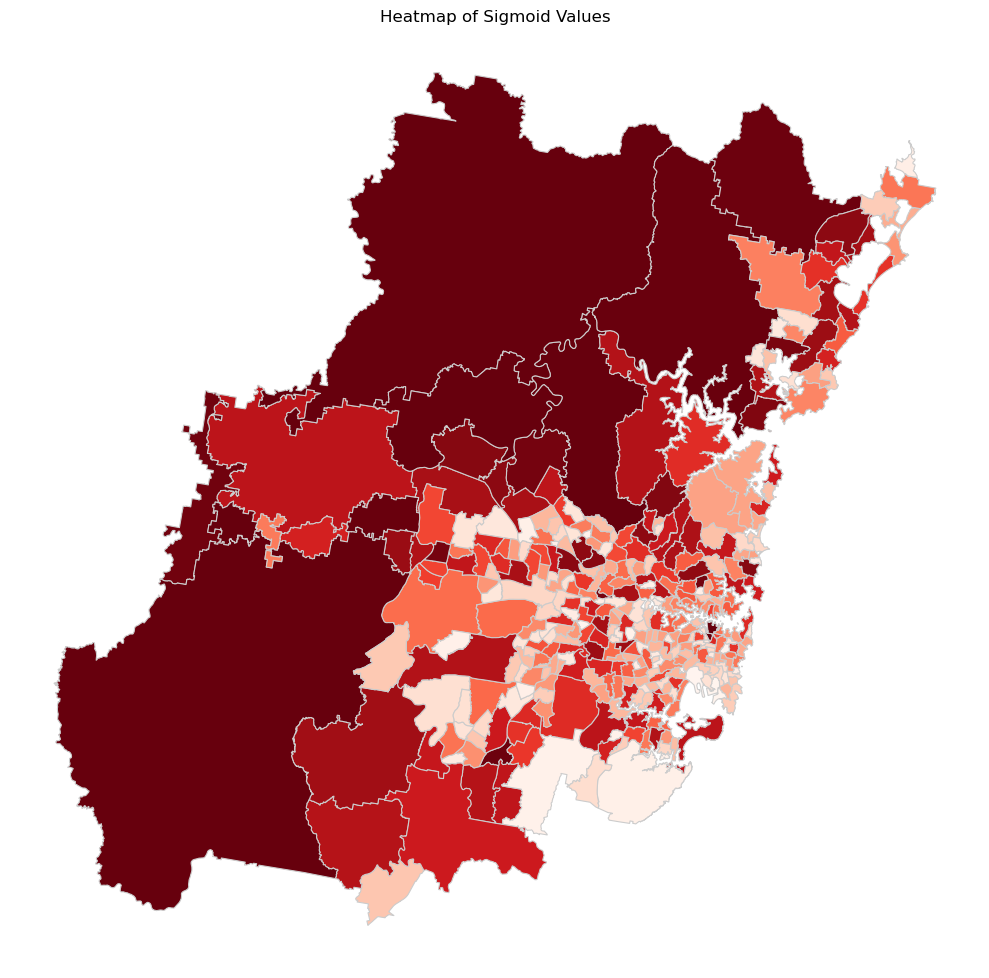

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the shapefile
data = gpd.read_file('datasets/cleaned/zscores/zscores.shp')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the heatmap
data.plot(column='SIGMOID', cmap='Reds', linewidth=0.8, edgecolor='0.8', ax=ax)

# Remove the axis
ax.axis('off')

# Add a title
ax.set_title('Heatmap of Sigmoid Values')

# Display the plot
plt.tight_layout()
plt.show()